In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/.conda/envs/psps/bin/python
farshed.abdukhakimov
cn-08
/home/farshed.abdukhakimov/projects/psps2


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.utils.data as data_utils
from torch.optim import SGD, Adam, Adagrad, Adadelta

import matplotlib.pyplot as plt

import experiments.loss_functions as lf
from experiments.utils import get_dataset

import scipy 

torch.set_default_dtype(torch.float64)

%load_ext line_profiler

/home/farshed.abdukhakimov/.conda/envs/psps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/farshed.abdukhakimov/.conda/envs/psps/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/farshed.abdukhakimov/.conda/envs/psps/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [4]:
import os 
from sklearn.datasets import load_svmlight_file

torch.manual_seed(0)
np.random.seed(0)

batch_size = 256
# dataset_name = "covtype.libsvm.binary" 
dataset_name = "mushrooms"
percentage = 1.0

EPOCHS = 1000
# train_dataloader, train_data, train_target = get_dataset(dataset_name, batch_size, scale_data)
datasets_path = os.getenv("LIBSVM_DIR")
trainX, trainY = load_svmlight_file(f"{datasets_path}/{dataset_name}")
sample = np.random.choice(trainX.shape[0], round(trainX.shape[0] * percentage), replace=False)

assert sample.shape == np.unique(sample).shape

trainX = trainX[sample]
trainY = trainY[sample]

train_data = torch.tensor(trainX.toarray())
train_target = torch.tensor(trainY)

train_load = TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=False)


scale = 10
r1 = -scale
r2 = scale
scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
scaling_vec = torch.pow(torch.e, scaling_vec)
train_data_scaled = scaling_vec * train_data

train_load_scaled = data_utils.TensorDataset(train_data_scaled, train_target)
train_dataloader_scaled = DataLoader(train_load_scaled, batch_size=batch_size, shuffle=True)

train = train_data, train_target, train_dataloader
train_scaled = train_data_scaled, train_target, train_dataloader_scaled

# loss_function = lf.logreg
# loss_grad = lf.grad_logreg
# loss_hessian = lf.hess_logreg

loss_function = lf.nllsq
# loss_grad = lf.grad_nllsq
# loss_hessian = lf.hess_nllsq

if loss_function == lf.logreg:
    train_target[train_target == train_target.unique()[0]] = torch.tensor(-1.0, dtype=torch.get_default_dtype())
    train_target[train_target == train_target.unique()[1]] = torch.tensor(1.0, dtype=torch.get_default_dtype())
    assert torch.equal(train_target.unique(), torch.tensor([-1.0, 1.0]))

elif loss_function == lf.nllsq:
    train_target[train_target == train_target.unique()[0]] = 0.0
    train_target[train_target == train_target.unique()[1]] = 1.0
    assert torch.equal(train_target.unique(), torch.tensor([0.0, 1.0]))

train_data.shape, (train_data.min(), train_data.max()), train_target.unique(), torch.linalg.cond(train_data), torch.linalg.cond(train_data_scaled)

(torch.Size([8124, 112]),
 (tensor(0.), tensor(1.)),
 tensor([0., 1.]),
 tensor(1.4928e+19),
 tensor(1.6707e+23))

In [4]:
np.random.seed(0)
n = 1000
d = 100
dataset_name = f"synthetic-regression-{n}x{d}"
modified = False
A = np.random.randn(n,d)

if modified:
    U, S, VH = np.linalg.svd(A)
    S *= 0.0
    S = np.asarray([1/((x+1)**2) for x in range(S.shape[0])])
    A = np.dot(U[:, :S.shape[0]] * S, VH)
    dataset_name += "-modified"

xopt = np.random.randn(d)
b = A @ xopt 
train_data = torch.Tensor(A)
train_target = torch.Tensor(b)
xopt = torch.Tensor(xopt)

batch_size = 1000
EPOCHS = 100

train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=False)


scale = 1
r1 = -scale
r2 = scale
scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
scaling_vec = torch.pow(torch.e, scaling_vec)
train_data_scaled = scaling_vec * train_data

train_load_scaled = torch.utils.data.TensorDataset(train_data_scaled, train_target)
train_dataloader_scaled = torch.utils.data.DataLoader(train_load_scaled, batch_size=batch_size, shuffle=False)

train = [train_data, train_target, train_dataloader]
train_scaled = [train_data_scaled, train_target, train_dataloader_scaled]

loss_function = lf.mse
loss_grad = lf.grad_mse
loss_hessian = lf.hess_mse

train_data.shape, torch.linalg.cond(train_data), torch.linalg.cond(train_data_scaled)

(torch.Size([1000, 100]), tensor(1.8599), tensor(8.3273))

In [75]:
torch.manual_seed(0)
np.random.seed(0)

n = 1000
d = 100

train_data = np.random.randn(n, d)
w_star = np.random.randn(d)

batch_size = 1000
EPOCHS = 100

# U, S, VH = np.linalg.svd(train_data)
# S *= 0.0
# S = np.asarray([1/((x+1)**2) for x in range(S.shape[0])])
# train_data = np.dot(U[:, :S.shape[0]] * S, VH)

dataset_name = f"synthetic-classification-{n}x{d}"

train_target = train_data @ w_star
train_target[train_target < 0.0] = 0.0 # -1.0
train_target[train_target > 0.0] = 1.0

train_data = torch.Tensor(train_data)
train_target = torch.Tensor(train_target)

train_load = TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=False)


scale = 5
r1 = -scale
r2 = scale
scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
scaling_vec = torch.pow(torch.e, scaling_vec)
train_data_scaled = scaling_vec * train_data

train_load_scaled = TensorDataset(train_data_scaled, train_target)
train_dataloader_scaled = DataLoader(train_load_scaled, batch_size=batch_size, shuffle=False)

train = train_data, train_target, train_dataloader
train_scaled = train_data_scaled, train_target, train_dataloader_scaled


loss_function = lf.nllsq
# loss_grad = lf.grad_logreg
# loss_hessian = lf.hess_logreg


if loss_function == lf.logreg:
    train_target[train_target == train_target.unique()[0]] = torch.tensor(-1.0, dtype=torch.get_default_dtype())
    train_target[train_target == train_target.unique()[1]] = torch.tensor(1.0, dtype=torch.get_default_dtype())
    assert torch.equal(train_target.unique(), torch.tensor([-1.0, 1.0]))

elif loss_function == lf.nllsq:
    train_target[train_target == train_target.unique()[0]] = 0.0
    train_target[train_target == train_target.unique()[1]] = 1.0
    assert torch.equal(train_target.unique(), torch.tensor([0.0, 1.0]))


train_data.shape, (train_data.min(), train_data.max()), train_target.unique(), torch.linalg.cond(train_data), torch.linalg.cond(train_data_scaled)

(torch.Size([1000, 100]),
 (tensor(-4.8521), tensor(4.2418)),
 tensor([0., 1.]),
 tensor(1.8599),
 tensor(21906.2465))

In [5]:
def run_optimizer(optimizer, dataset, EPOCHS, seed=0, **kwargs_optimizer):

    data, target, dataloader = dataset

    torch.manual_seed(seed)

    # parameters
    w = torch.zeros(data.shape[1], device=device).requires_grad_()
    opt = optimizer([w], **kwargs_optimizer)

    # logging 
    hist = []
    
    def compute_loss(w, data, target):
        loss = loss_function(w, data, target)
        loss.backward()
        return loss
    
    def compute_loss_graph(w, data, target):
        loss = loss_function(w, data, target)
        loss.backward(create_graph=True)
        return loss


    for epoch in range(EPOCHS):

        loss = loss_function(w, data.to(device), target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        acc = (np.sign(data @ w.detach().numpy()) == target).sum() / target.shape[0]
        print(f"[{epoch}/{EPOCHS}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()} | Acc: {acc}")
        hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), acc])

        for i, (batch_data, batch_target) in enumerate(dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)
            opt.zero_grad()
            # if isinstance(opt, Momo):
            #     closure = lambda: compute_loss(w, batch_data, batch_target)
            #     opt.step(closure=closure)
            # elif isinstance(opt, Custom):
            #     closure = lambda: compute_loss_graph(w, batch_data, batch_target)
            #     opt.step(closure=closure)
            # else:
            loss = compute_loss(w, batch_data, batch_target)
            opt.step()

    return hist



def save_results(result, dataset_name, percentage, scale, batch_size, epochs, loss_function_name, optimizer_name, lr, 
                 precond_method, pcg_method, hutch_init_iters, seed):
    
    results_path = os.getenv("RESULTS_DIR")
    directory = f"{results_path}/{dataset_name}/percentage_{percentage}/scale_{scale}/bs_{batch_size}" \
    f"/epochs_{epochs}/{loss_function_name}/{optimizer_name}/lr_{lr}/precond_{precond_method}/pcg_method_{pcg_method}/hutch_init_iters_{hutch_init_iters}/seed_{seed}"

    print(directory)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    torch.save([x[0] for x in result], f"{directory}/loss")
    torch.save([x[1] for x in result], f"{directory}/grad_norm_sq")
    torch.save([x[2] for x in result], f"{directory}/acc")

# PSPS2 Rank 1 Scaling
$
w^* = \arg\min_{w\in\mathbb{R} ^d}\frac{1}{2} \|w - w_t\|_{B_t} \nonumber \\
      \text{s.t.} \quad f_i(w_t) +  \langle  \nabla  f_i(w_t), w-w_t\rangle +\frac{1}{2}\langle B_t(w-w^t), w - w^t \rangle \leq 0 \\ 
      B_t = \frac{yy^T}{s^Ty} \\ 
      B_t^{+} = \frac{ss^T}{s^Ty} \\ 
      \text{where} \quad s = \Big ( \nabla^2  f_i(w_t) \Big ) ^{-1} \nabla f_i(w_t) \\ 
      y = \nabla^2 f_i(w_t) s = \nabla f_i(w_t) \\ 
      \text{Update Rule: } \\
      w_{t+1} = w_t - \frac{\alpha}{1 + \alpha} B_t^{+} \nabla f_i(w_t)
$

In [27]:
def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))
    return torch.mean(torch.stack(Ds), 0)

def run_psps2(dataset, epochs, precond_method, pcg_method="none", seed=0, **kwargs):

    torch.manual_seed(seed)

    data, target, dataloader = dataset

    eps = kwargs.get("eps", 1e-6)

    # torch.manual_seed(seed)
    
    # parameters
    w = torch.zeros(data.shape[1], device=device).requires_grad_()

    # save loss and grad size to history
    hist = []

    opt = Adam([w], lr=0.1)
    

    opt.zero_grad()
    loss = loss_function(w, data.to(device), target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    f_grad = g.clone().detach() 


    if precond_method == "none":
        D = torch.ones_like(w)
    elif precond_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk = diag_estimate_old(w, g, init_iters)
    elif precond_method == "pcg":
        MAX_ITER = train_data.shape[1] * 2

    elif precond_method == "scaling_vec":
        scaling_vec = kwargs["scaling_vec"]
        D = (1 / scaling_vec)**2
    elif precond_method == "adam" or precond_method == "adam_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)
        step_t = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif precond_method == "adagrad" or precond_method == "adagrad_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)

    if pcg_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk_pcg = diag_estimate_old(w, g, init_iters)
    elif pcg_method == "adam" or pcg_method == "adam_m":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
        step_t_pcg = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif pcg_method == "adagrad" or pcg_method == "adagrad_m":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
    elif pcg_method == "none":
        D_pcg = torch.ones_like(g)

    cg_steps = []

    for epoch in range(epochs):

        opt.zero_grad()
        loss = loss_function(w, data.to(device), target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2  
        acc = (np.sign(data @ w.detach().numpy()) == target).sum() / target.shape[0]

        print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
        hist.append([loss.item(), grad_norm_sq.item(), acc])
           
        for i, (batch_data, batch_target) in enumerate(dataloader): 
            
            # opt.zero_grad()
            # loss = loss_function(w, data.to(device), target.to(device))
            # g, = torch.autograd.grad(loss, w, create_graph=True)
            # grad_norm_sq = torch.linalg.norm(g) ** 2  
            # print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()}")

            opt.zero_grad()
            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.detach().clone()

            if precond_method == "hess_diag":
                hess = loss_hessian(w, batch_data, batch_target)
                # closure = lambda w: loss_function(w, batch_data, batch_target)
                # hess = torch.autograd.functional.hessian(closure, w)
                hess_diag_inv = 1 / torch.diag(hess)
                s = hess_diag_inv * f_grad

            elif precond_method == "true_hessian":
                closure = lambda w: loss_function(w, batch_data, batch_target)
                hess = torch.autograd.functional.hessian(closure, w)
                # hess = loss_hessian(w, batch_data, batch_target)
                s = torch.linalg.solve(hess, f_grad)
                # hess[hess <= 0.01] = 0.01
                # hess_inv = torch.linalg.inv(hess)
                # s = hess_inv @ f_grad

            elif precond_method == "scaling_vec":
                s = D * f_grad

            elif precond_method in ("adam", "adam_m"):
                step_t += 1
                v = betas[1] * v + (1 - betas[1]) * g.square()
                v_hat = v / (1 - torch.pow(betas[1], step_t))

                if precond_method == "adam":
                    D = 1 / (torch.sqrt(v_hat) + eps)
                else:
                    D = 1 / (v_hat + eps) 
                s = D * f_grad

            elif precond_method in ("adagrad", "adagrad_m"):
                v.add_(torch.square(g))
                if precond_method == "adagrad":
                    D = 1 / (torch.sqrt(v) + eps)
                else:
                    D = 1 / (v + eps)
                s = D * f_grad

            elif precond_method == "scipy_cg":
                A = scipy.sparse.csc_matrix(loss_hessian(w, batch_data, batch_target).detach().numpy())
                s, exit_code = scipy.sparse.linalg.cg(A, f_grad.numpy(), tol=1e-10)
                s = torch.tensor(s)

            elif precond_method == "none":
                s = D * f_grad

            elif precond_method == "hutch":
                vk = diag_estimate_old(w, g, 1)

                # Smoothing and Truncation 
                Dk = beta * Dk + (1 - beta) * vk
                Dk_hat = torch.abs(Dk)
                Dk_hat[Dk_hat < alpha] = alpha

                D = 1 / Dk_hat
                s = D * f_grad

            elif precond_method == "pcg":

                if pcg_method == "hutch":
                    vk_pcg = diag_estimate_old(w, g, 1)
                    # Smoothing and Truncation 
                    Dk_pcg = beta * Dk_pcg + (1 - beta) * vk_pcg
                    Dk_hat = torch.abs(Dk_pcg)
                    Dk_hat[Dk_hat < alpha] = alpha
                    D_pcg = 1 / Dk_hat

                elif pcg_method == "adam":
                    step_t_pcg += 1
                    v_pcg = betas[1] * v_pcg + (1 - betas[1]) * f_grad.square()
                    v_hat = v_pcg / (1 - torch.pow(betas[1], step_t_pcg))
                    # if pcg_method == "adam":
                    # D_pcg = 1 / (torch.sqrt(v_hat) + 1e-12)
                    # else:
                    D_pcg = 1 / (v_hat + 1e-6)

                elif pcg_method == "adagrad":
                    v_pcg.add_(f_grad.square())
                    # if pcg_method == "adagrad":
                    #     D_pcg = 1 / (torch.sqrt(v_pcg) + 1e-8)
                    # else:   
                    D_pcg = 1 / (v_pcg + 1e-6)


                hess_diag_inv = D_pcg.clone()
                # Preconditioned CG is here
                s = torch.zeros_like(w) # s = H_inv * grad
                r = f_grad.clone()
                z = hess_diag_inv * r
                p = z.detach().clone()

                for cg_step in range(MAX_ITER):
                    hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                    alpha_k = torch.dot(r, z) / torch.dot(p, hvp)
                    # if torch.dot(p, hvp) <= 0:
                    #     gamma = 0.5
                    #     s = gamma * s * torch.sign(torch.dot(s, f_grad)) + (1 - gamma) * p * torch.sign(torch.dot(p ,f_grad))
                    #     # s = p.clone()
                    #     break

                    s = s + alpha_k * p
                    r_prev = r.clone()
                    r = r - alpha_k * hvp
                    r_hat = torch.autograd.grad(g, w, grad_outputs=r, retain_graph=True)[0] 
                    z_prev = z.clone()
                    z = hess_diag_inv * r
                    if torch.dot(r, r_hat) < 1e-14:
                        break
                    

                    beta_k = torch.dot(r, z) / torch.dot(r_prev, z_prev)
                    p = z + beta_k * p    

            grad_norm_sq_scaled = torch.dot(f_grad, s)

            if 2 * loss <= ( grad_norm_sq_scaled ):
                c = loss / ( grad_norm_sq_scaled )
                det = 1 - 2 * c
                step_size = 1 - torch.sqrt(det)
            else:
                step_size = 1.0

            # print(f"{loss=}")
            # print(f"{step_size=}")
            # print(f"{torch.norm(s)=}")
            with torch.no_grad():
                w.sub_(step_size * s)
            # opt.zero_grad()        
            # loss = loss_function(w, batch_data, batch_target)
            # print(loss)

    return hist

In [75]:
EPOCHS = 500

In [60]:
# lr = 0.001
# for opt in [Adam, Adagrad, Adadelta]:
#     for seed in [0, 1, 2, 3, 4]:
#         for t, s in zip([train, train_scaled], [0, scale]):
#             hist = run_optimizer(opt, t, EPOCHS, seed=seed, lr=lr)
#             save_results(hist, dataset_name, 1.0, s, batch_size, EPOCHS, loss_function.__name__, opt.__name__.lower(), lr, "none", "none", 1000, seed)


[0/500] | Loss: 0.25 | GradNorm^2: 0.07989174018857569 | Acc: 0.48202855736090594
[1/500] | Loss: 0.19784776220905426 | GradNorm^2: 0.05427963171258391 | Acc: 0.5126784835056623
[2/500] | Loss: 0.15919794412952296 | GradNorm^2: 0.035076864524490756 | Acc: 0.5110782865583456
[3/500] | Loss: 0.13199405219247176 | GradNorm^2: 0.02247669997755217 | Acc: 0.5110782865583456
[4/500] | Loss: 0.11280561456448203 | GradNorm^2: 0.014845568118557972 | Acc: 0.5109551944854751
[5/500] | Loss: 0.09881997120095941 | GradNorm^2: 0.010259120302141633 | Acc: 0.5104628261939931
[6/500] | Loss: 0.08818681020675272 | GradNorm^2: 0.007427950997972607 | Acc: 0.5097242737567701
[7/500] | Loss: 0.07977070683433843 | GradNorm^2: 0.0056068917297523195 | Acc: 0.5093549975381585
[8/500] | Loss: 0.07288302965274351 | GradNorm^2: 0.004380586072851749 | Acc: 0.5088626292466765
[9/500] | Loss: 0.0670989491554793 | GradNorm^2: 0.0035171034666408173 | Acc: 0.5088626292466765
[10/500] | Loss: 0.062147254604344206 | GradNo

In [61]:
# for precond in ["adagrad_m"]:
#     for seed in [0, 1, 2, 3, 4]:
#         for t, s, eps in zip([train, train_scaled], [0, scale], [1e-6, 1e-9]):
#             hist = run_psps2(t, EPOCHS, precond, "none", seed, eps=eps)
#             save_results(hist, dataset_name, 1.0, s, batch_size, EPOCHS, loss_function.__name__, "psps2", 1.0, precond, "none", 1000, seed)

[0/500] | Loss: 0.25 | GradNorm^2: 0.07989174018857569 | Accuracy: 0.48202855736090594


[1/500] | Loss: 0.0016143917556106795 | GradNorm^2: 2.1061197069539405e-05 | Accuracy: 0.517971442639094
[2/500] | Loss: 0.0005872857616941672 | GradNorm^2: 5.160597131271729e-06 | Accuracy: 0.517479074347612
[3/500] | Loss: 8.976234728611797e-05 | GradNorm^2: 2.4542849714014908e-08 | Accuracy: 0.517971442639094
[4/500] | Loss: 4.7514743373297576e-05 | GradNorm^2: 3.839161936247792e-09 | Accuracy: 0.517971442639094
[5/500] | Loss: 2.9978829566684918e-05 | GradNorm^2: 1.3480055983163099e-09 | Accuracy: 0.517971442639094
[6/500] | Loss: 2.4463628780421704e-05 | GradNorm^2: 6.458697851721917e-09 | Accuracy: 0.517971442639094
[7/500] | Loss: 1.6627860155907637e-05 | GradNorm^2: 1.07891114267714e-09 | Accuracy: 0.517971442639094
[8/500] | Loss: 1.364835783980352e-05 | GradNorm^2: 5.542221334315775e-10 | Accuracy: 0.517971442639094
[9/500] | Loss: 1.1647778210515487e-05 | GradNorm^2: 3.450564214017511e-10 | Accuracy: 0.517971442639094
[10/500] | Loss: 1.0184499501221505e-05 | GradNorm^2: 2.3

In [145]:
for precond in ["adam_m"]:
    for seed in [0, 1, 2, 3, 4]:
        # for t, s, eps in zip([train, train_scaled], [0, scale], [1e-6, 1e-9]):
        t = train_scaled
        s = scale
        hist = run_psps2(t, EPOCHS, precond, "none", seed, eps=1e-8)
        save_results(hist, dataset_name, 1.0, s, batch_size, EPOCHS, loss_function.__name__, "psps2", 1.0, precond, "none", 1000, seed)

[0/100] | Loss: 0.25 | GradNorm^2: 243291.47452927433 | Accuracy: 0.48202855736090594
[1/100] | Loss: 0.0023693418848133325 | GradNorm^2: 106.61228997613944 | Accuracy: 0.517971442639094
[2/100] | Loss: 0.0002363590550759668 | GradNorm^2: 0.08843327570879653 | Accuracy: 0.517971442639094
[3/100] | Loss: 5.9294764176101316e-05 | GradNorm^2: 0.09804497654128544 | Accuracy: 0.517971442639094
[4/100] | Loss: 1.71543138138221e-05 | GradNorm^2: 0.004427288380480365 | Accuracy: 0.517971442639094
[5/100] | Loss: 3.1627638877115925e-05 | GradNorm^2: 0.1521657782207888 | Accuracy: 0.517971442639094
[6/100] | Loss: 3.323544476710872e-05 | GradNorm^2: 0.23296184081080185 | Accuracy: 0.517971442639094
[7/100] | Loss: 3.985984597303156e-06 | GradNorm^2: 0.0030003266431725137 | Accuracy: 0.517971442639094
[8/100] | Loss: 3.0436156983165696e-06 | GradNorm^2: 0.0020754425520869155 | Accuracy: 0.517971442639094
[9/100] | Loss: 9.170979228168758e-07 | GradNorm^2: 9.993234005568183e-05 | Accuracy: 0.51797

KeyboardInterrupt: 

In [76]:
hist_adam = run_optimizer(Adam, train, EPOCHS, lr=0.001)
hist_adam_scaled = run_optimizer(Adam, train_scaled, EPOCHS, lr=0.001)

hist_adagrad = run_optimizer(Adagrad, train, EPOCHS, lr=0.001)
hist_adagrad_scaled = run_optimizer(Adagrad, train_scaled, EPOCHS, lr=0.001)

[0/100] | Loss: 0.25 | GradNorm^2: 0.07989174018857569 | Acc: 0.48202855736090594
[1/100] | Loss: 0.19784776220905426 | GradNorm^2: 0.05427963171258391 | Acc: 0.5126784835056623
[2/100] | Loss: 0.15919794412952296 | GradNorm^2: 0.035076864524490756 | Acc: 0.5110782865583456
[3/100] | Loss: 0.13199405219247176 | GradNorm^2: 0.02247669997755217 | Acc: 0.5110782865583456
[4/100] | Loss: 0.11280561456448203 | GradNorm^2: 0.014845568118557972 | Acc: 0.5109551944854751
[5/100] | Loss: 0.09881997120095941 | GradNorm^2: 0.010259120302141633 | Acc: 0.5104628261939931
[6/100] | Loss: 0.08818681020675272 | GradNorm^2: 0.007427950997972607 | Acc: 0.5097242737567701
[7/100] | Loss: 0.07977070683433843 | GradNorm^2: 0.0056068917297523195 | Acc: 0.5093549975381585
[8/100] | Loss: 0.07288302965274351 | GradNorm^2: 0.004380586072851749 | Acc: 0.5088626292466765
[9/100] | Loss: 0.0670989491554793 | GradNorm^2: 0.0035171034666408173 | Acc: 0.5088626292466765
[10/100] | Loss: 0.062147254604344206 | GradNo

In [142]:
hist_psps2_adam = run_psps2(train, EPOCHS, "adam_m", "none", seed=3, eps=1e-6)

[0/100] | Loss: 0.25 | GradNorm^2: 0.07989174018857569 | Accuracy: 0.48202855736090594
[1/100] | Loss: 0.0020696208976965277 | GradNorm^2: 5.9214766615540016e-05 | Accuracy: 0.5173559822747416
[2/100] | Loss: 0.0001887880411441512 | GradNorm^2: 4.337403639497588e-08 | Accuracy: 0.517971442639094
[3/100] | Loss: 8.297060677900699e-05 | GradNorm^2: 2.907342088202796e-08 | Accuracy: 0.517971442639094
[4/100] | Loss: 6.169350601258914e-05 | GradNorm^2: 1.0184059797022313e-07 | Accuracy: 0.517971442639094
[5/100] | Loss: 4.603724922653458e-05 | GradNorm^2: 6.737153414272438e-08 | Accuracy: 0.517971442639094
[6/100] | Loss: 3.40763192503095e-05 | GradNorm^2: 4.2502797838657404e-08 | Accuracy: 0.517971442639094
[7/100] | Loss: 1.6475679213152793e-05 | GradNorm^2: 1.2778428574273647e-08 | Accuracy: 0.517971442639094
[8/100] | Loss: 5.378785805321761e-06 | GradNorm^2: 1.6466449584454313e-09 | Accuracy: 0.517971442639094
[9/100] | Loss: 3.876282582986469e-06 | GradNorm^2: 8.940864020252461e-10 |

[12/100] | Loss: 1.0017076417613422e-06 | GradNorm^2: 6.117026783856214e-11 | Accuracy: 0.517971442639094
[13/100] | Loss: 5.547863166761656e-07 | GradNorm^2: 1.737513527351704e-11 | Accuracy: 0.517971442639094
[14/100] | Loss: 3.0611247871330807e-07 | GradNorm^2: 4.464989229636384e-12 | Accuracy: 0.517971442639094
[15/100] | Loss: 1.7018287289063063e-07 | GradNorm^2: 9.779931171548688e-13 | Accuracy: 0.517971442639094
[16/100] | Loss: 9.623758782118518e-08 | GradNorm^2: 1.4669369274129317e-13 | Accuracy: 0.517971442639094
[17/100] | Loss: 5.4009960688815536e-08 | GradNorm^2: 3.393282638040307e-15 | Accuracy: 0.517971442639094
[18/100] | Loss: 4.515429684831968e-08 | GradNorm^2: 3.2899361876978927e-15 | Accuracy: 0.517971442639094
[19/100] | Loss: 3.885519606708713e-08 | GradNorm^2: 5.6644267067912335e-15 | Accuracy: 0.517971442639094
[20/100] | Loss: 3.7338487099109816e-08 | GradNorm^2: 1.6362776316474392e-14 | Accuracy: 0.517971442639094
[21/100] | Loss: 2.9562716572901868e-08 | Grad

In [143]:
hist_psps2_adam_scaled = run_psps2(train_scaled, EPOCHS, "adam_m", "none", seed=3, eps=1e-8)

[0/100] | Loss: 0.25 | GradNorm^2: 243291.47452927433 | Accuracy: 0.48202855736090594
[1/100] | Loss: 0.00310948495167661 | GradNorm^2: 129.6865499095567 | Accuracy: 0.517971442639094
[2/100] | Loss: 0.00031818996773664594 | GradNorm^2: 1.5397226878422878 | Accuracy: 0.517971442639094
[3/100] | Loss: 8.246549537516095e-05 | GradNorm^2: 0.45296301908794295 | Accuracy: 0.517971442639094
[4/100] | Loss: 1.1555054196817578e-05 | GradNorm^2: 0.002735883615320641 | Accuracy: 0.517971442639094
[5/100] | Loss: 1.929365212100709e-05 | GradNorm^2: 0.06763961015104801 | Accuracy: 0.517971442639094
[6/100] | Loss: 3.7343029265580124e-06 | GradNorm^2: 0.0016598102895394895 | Accuracy: 0.517971442639094
[7/100] | Loss: 2.2817997215504868e-06 | GradNorm^2: 0.000838868281728712 | Accuracy: 0.517971442639094
[8/100] | Loss: 5.380958944144244e-07 | GradNorm^2: 4.301642745601347e-06 | Accuracy: 0.517971442639094
[9/100] | Loss: 3.3119915118389264e-07 | GradNorm^2: 1.3904081557337087e-07 | Accuracy: 0.517

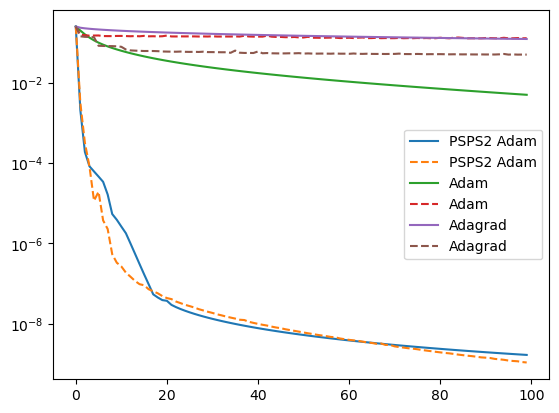

In [144]:
# plt.semilogy([x[0] for x in hist_pcg_adam], label="PSPS2 PCG Adam")
# plt.semilogy([x[0] for x in hist_pcg_adam_scaled], linestyle="--", label="PSPS2 PCG Adam")

# plt.semilogy([x[0] for x in hist_pcg_adagrad], label="PSPS2 PCG Adagrad")
# plt.semilogy([x[0] for x in hist_pcg_adagrad_scaled], linestyle="--", label="PSPS2 PCG Adagrad")

# plt.semilogy([x[0] for x in hist_psps2_newton], label="PSPS2 Newton")
# plt.semilogy([x[0] for x in hist_psps2_newton_scaled], linestyle="--", label="PSPS2 Newton")

plt.semilogy([x[0] for x in hist_psps2_adam], label="PSPS2 Adam")
plt.semilogy([x[0] for x in hist_psps2_adam_scaled], linestyle="--", label="PSPS2 Adam")

# plt.semilogy([x[0] for x in hist_psps2_adagrad], label="PSPS2 Adagrad")
# plt.semilogy([x[0] for x in hist_psps2_adagrad_scaled], linestyle="--", label="PSPS2 Adagrad")

plt.semilogy([x[0] for x in hist_adam], label="Adam")
plt.semilogy([x[0] for x in hist_adam_scaled], linestyle="--", label="Adam")

plt.semilogy([x[0] for x in hist_adagrad], label="Adagrad")
plt.semilogy([x[0] for x in hist_adagrad_scaled], linestyle="--", label="Adagrad")


# plt.ylim(bottom=1e-2)

plt.legend()
# plt.savefig(f"experiments/plots/testtest.jpeg", format="jpeg", dpi=200)

# Non-Convex PSPS2 CG

In [24]:
def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)

def run_psps2_nc(train_data, train_target, train_dataloader, epochs, precond_method="cg", seed=0, **kwargs):

    torch.manual_seed(seed)

    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    # save loss and grad size to history
    hist = []


    loss = loss_function(w, train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    f_grad = g.clone().detach()


    if precond_method == "cg" or precond_method == "pcg":
        s = torch.zeros_like(w) # s = H_inv * grad
        r = f_grad - torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
        p = r.detach().clone()
        r_prev = torch.dot(r, r)
        MAX_ITER = train_data.shape[1] * 2
        # MAX_ITER = 1000


    for epoch in range(epochs):

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]

        print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
        hist.append([loss.item(), grad_norm_sq.item(), acc])

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.detach().clone()

            # ssstep = 1.0

            if i % 64 == 0:
                loss = loss_function(w, train_data.to(device), train_target.to(device))
                g, = torch.autograd.grad(loss, w, create_graph=True)
                grad_norm_sq = torch.linalg.norm(g) ** 2
                print(f"[{epoch}][{i}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
                # hist.append([loss.item(), grad_norm_sq.item(), acc])

            if precond_method == "cg":


                # estimate the TR radius from Polyak-step-size
                trDelta = (loss / ( f_grad.dot(f_grad) )).item()
                # print("trDelta",trDelta)


                gamma=0.9

                # CG is here
                s = torch.zeros_like(w) # s = H_inv * grad
                z = torch.zeros_like(w)
                r = f_grad.clone()
                p = r.clone()
                # tt=f_grad.clone()
                for cg_step in range(MAX_ITER):
                    hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]

                    # print(torch.dot(p,hvp))
                    if torch.dot(p,hvp)<=0: 
                        # print("NEGATIVE CURVATURE")
                        # if torch.dot(p,f_grad)<=0:
                        s=gamma*z*torch.sign(torch.dot(z,f_grad))+(1-gamma)*p*torch.sign(torch.dot(p,f_grad))
                        # else:
                            # s=-p
                        # hvs = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
                        # ssstep=torch.dot(s,f_grad)/torch.dot(s,hvs)
                        step_size=torch.min(torch.tensor([loss/torch.dot(s,s),50]))
                        # print("*")
                        break



                    # print(">",cg_step)
                    # print(">",torch.dot(p,hvp))
                    alpha_k = torch.dot(r, r) / torch.dot(p, hvp)
                    z = z + alpha_k * p
                    r_prev = r.clone()
                    r = r - alpha_k * hvp
                    if torch.norm(r) < 1e-4:
                        s=z
                        # hvs = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
    
                        # Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
                        # diff = torch.norm(Ax - f_grad)
                        # print(f"CG Took {cg_step} to reach diff={diff}")
                        # cg_steps.append(cg_step)
                        grad_norm_sq_scaled = torch.dot(f_grad, s)
                        if 2 * loss <= grad_norm_sq_scaled:
                            c = loss / ( grad_norm_sq_scaled )
                            det = 1 - 2 * c
                            if det < 0.0:
                                step_size = 1.0
                            else:
                                # print("**")
                                step_size = 1 - torch.sqrt(det)
                        else:
                            # print(f"[{epoch}, {i}] No solution")
                            # print("***")
                            step_size = 1.0
                        
                        
                        break

                    beta_k = torch.dot(r, r) / torch.dot(r_prev, r_prev)
                    p = r + beta_k * p

            step_size = step_size
            # print("step_size",step_size)
            # FB =  loss_function(w, train_data.to(device), train_target.to(device))
            # FBB =  loss_function(w, batch_data, batch_target)
            with torch.no_grad():
                w.sub_(step_size *s)
            # FA =  loss_function(w, train_data.to(device), train_target.to(device))
            # FAA =  loss_function(w, batch_data, batch_target)
            
            # print(FA - FB, " <<< 0", FAA - FBB)
            # if i > 50:
            #   return ''

    return hist


In [34]:
hist_cg = run_psps2_nc(train_data, train_target, train_dataloader, EPOCHS, precond_method="cg", seed=2)
hist_cg_scaled = run_psps2_nc(train_data_scaled, train_target, train_dataloader_scaled, EPOCHS, precond_method="cg", seed=2)

[0/1000] | Loss: 0.25 | GradNorm^2: 0.07989174018857569 | Accuracy: 0.48202855736090594
[0][0] | Loss: 0.25 | GradNorm^2: 0.07989174018857569 | Accuracy: 0.48202855736090594
[1/1000] | Loss: 0.023333788196273696 | GradNorm^2: 0.00024317355529932547 | Accuracy: 0.5091088133924175
[1][0] | Loss: 0.023333788196273696 | GradNorm^2: 0.00024317355529932547 | Accuracy: 0.5091088133924175
[2/1000] | Loss: 0.005571820399715342 | GradNorm^2: 1.0199563316405565e-06 | Accuracy: 0.5150172328902018
[2][0] | Loss: 0.005571820399715342 | GradNorm^2: 1.0199563316405565e-06 | Accuracy: 0.5150172328902018
[3/1000] | Loss: 0.005330529197714774 | GradNorm^2: 2.704000939804222e-07 | Accuracy: 0.5150172328902018
[3][0] | Loss: 0.005330529197714774 | GradNorm^2: 2.704000939804222e-07 | Accuracy: 0.5150172328902018
[4/1000] | Loss: 0.005284009922532632 | GradNorm^2: 3.5247278455888173e-07 | Accuracy: 0.5150172328902018
[4][0] | Loss: 0.005284009922532632 | GradNorm^2: 3.5247278455888173e-07 | Accuracy: 0.51501

[6/1000] | Loss: 0.005278432542137247 | GradNorm^2: 3.268743890417707e-07 | Accuracy: 0.5150172328902018
[6][0] | Loss: 0.005278432542137247 | GradNorm^2: 3.268743890417707e-07 | Accuracy: 0.5150172328902018
[7/1000] | Loss: 0.005273327966656881 | GradNorm^2: 3.3648273067897114e-07 | Accuracy: 0.5150172328902018
[7][0] | Loss: 0.005273327966656881 | GradNorm^2: 3.3648273067897114e-07 | Accuracy: 0.5150172328902018
[8/1000] | Loss: 0.005291363910658603 | GradNorm^2: 2.6128701351814726e-07 | Accuracy: 0.5150172328902018
[8][0] | Loss: 0.005291363910658603 | GradNorm^2: 2.6128701351814726e-07 | Accuracy: 0.5150172328902018
[9/1000] | Loss: 0.005376123841902015 | GradNorm^2: 2.6943375123480042e-08 | Accuracy: 0.5150172328902018
[9][0] | Loss: 0.005376123841902015 | GradNorm^2: 2.6943375123480042e-08 | Accuracy: 0.5150172328902018
[10/1000] | Loss: 0.005366704830309771 | GradNorm^2: 3.0513382326233085e-08 | Accuracy: 0.5150172328902018
[10][0] | Loss: 0.005366704830309771 | GradNorm^2: 3.05

In [30]:
hist_adam = run_optimizer(Adam, train_data, train_target, train_dataloader, EPOCHS, lr=0.1)
hist_adam_scaled = run_optimizer(Adam, train_data_scaled, train_target, train_dataloader_scaled, EPOCHS, lr=0.01)

[0/1000] | Loss: 0.25 | GradNorm^2: 0.07989174018857569 | Acc: 0.48202855736090594
[1/1000] | Loss: 0.005549358439035377 | GradNorm^2: 0.00012296265117304355 | Acc: 0.5155096011816839


[2/1000] | Loss: 0.001974929028017897 | GradNorm^2: 1.0096106103985234e-05 | Acc: 0.517725258493353
[3/1000] | Loss: 0.001149566784282265 | GradNorm^2: 2.9745717358142637e-06 | Acc: 0.517971442639094
[4/1000] | Loss: 0.0008282066644832274 | GradNorm^2: 1.5806122636570274e-06 | Acc: 0.517971442639094
[5/1000] | Loss: 0.0006073368399890262 | GradNorm^2: 6.84283974255798e-07 | Acc: 0.517971442639094
[6/1000] | Loss: 0.00045314867349830574 | GradNorm^2: 2.894456139634241e-07 | Acc: 0.517971442639094
[7/1000] | Loss: 0.000355583802824161 | GradNorm^2: 1.2909608195302764e-07 | Acc: 0.517971442639094
[8/1000] | Loss: 0.0002896595673847308 | GradNorm^2: 5.232855347153612e-08 | Acc: 0.517971442639094
[9/1000] | Loss: 0.0002426019372810867 | GradNorm^2: 2.3867811059702884e-08 | Acc: 0.517971442639094
[10/1000] | Loss: 0.00020757662468706326 | GradNorm^2: 1.6546977279593597e-08 | Acc: 0.517971442639094
[11/1000] | Loss: 0.0001804325477155355 | GradNorm^2: 1.4352740528738079e-08 | Acc: 0.517971442

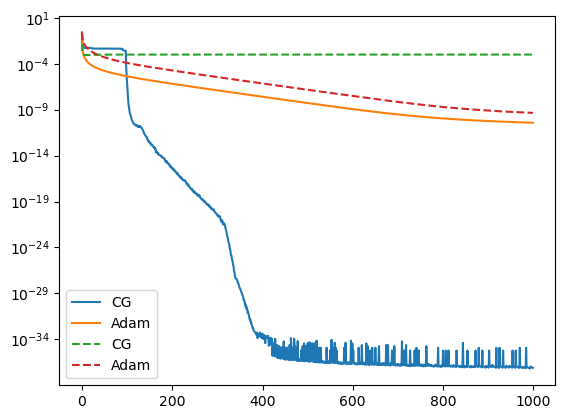

In [35]:
plt.semilogy([x[0] for x in hist_cg], label="CG")
plt.semilogy([x[0] for x in hist_adam], label="Adam")

plt.semilogy([x[0] for x in hist_cg_scaled], linestyle="--", label="CG")
plt.semilogy([x[0] for x in hist_adam_scaled], linestyle="--", label="Adam")

plt.legend()

# plt.savefig(f"experiments/plots/non-convex-cg_vs_adam-gamma-0_1.jpeg", format="jpeg", dpi=200)


In [40]:
for seed in [5, 7]:
    hist = run_psps2_nc(train_data, train_target, train_dataloader, 1000, "cg", seed=seed)
    save_results(hist, dataset_name, 1.0, 0, batch_size, 1000, loss_function.__name__, "psps2", 1.0, "pcg", "none", 1000, seed)

[0/1000] | Loss: 0.25 | GradNorm^2: 0.07989174018857569 | Accuracy: 0.48202855736090594
[0][0] | Loss: 0.25 | GradNorm^2: 0.07989174018857569 | Accuracy: 0.48202855736090594
[1/1000] | Loss: 0.023333788196273696 | GradNorm^2: 0.00024317355529932547 | Accuracy: 0.5091088133924175
[1][0] | Loss: 0.023333788196273696 | GradNorm^2: 0.00024317355529932547 | Accuracy: 0.5091088133924175
[2/1000] | Loss: 0.005571820399715342 | GradNorm^2: 1.0199563316405565e-06 | Accuracy: 0.5150172328902018
[2][0] | Loss: 0.005571820399715342 | GradNorm^2: 1.0199563316405565e-06 | Accuracy: 0.5150172328902018
[3/1000] | Loss: 0.005330529197714774 | GradNorm^2: 2.704000939804222e-07 | Accuracy: 0.5150172328902018
[3][0] | Loss: 0.005330529197714774 | GradNorm^2: 2.704000939804222e-07 | Accuracy: 0.5150172328902018
[4/1000] | Loss: 0.005284009922532632 | GradNorm^2: 3.5247278455888173e-07 | Accuracy: 0.5150172328902018
[4][0] | Loss: 0.005284009922532632 | GradNorm^2: 3.5247278455888173e-07 | Accuracy: 0.51501

In [41]:
for seed in [5, 7]:
    hist = run_psps2_nc(train_data_scaled, train_target, train_dataloader_scaled, 1000, "cg", seed=seed)
    save_results(hist, dataset_name, 1.0, scale, batch_size, 1000, loss_function.__name__, "psps2", 1.0, "pcg", "none", 1000, seed)

[0/1000] | Loss: 0.25 | GradNorm^2: 0.10443737961563863 | Accuracy: 0.48202855736090594
[0][0] | Loss: 0.25 | GradNorm^2: 0.10443737961563863 | Accuracy: 0.48202855736090594


[1/1000] | Loss: 0.0026907413763441025 | GradNorm^2: 3.5454628445080996e-06 | Accuracy: 0.517971442639094
[1][0] | Loss: 0.0026907413763441025 | GradNorm^2: 3.5454628445080996e-06 | Accuracy: 0.517971442639094
[2/1000] | Loss: 0.00235438513610642 | GradNorm^2: 8.51404253809818e-06 | Accuracy: 0.517971442639094
[2][0] | Loss: 0.00235438513610642 | GradNorm^2: 8.51404253809818e-06 | Accuracy: 0.517971442639094
[3/1000] | Loss: 0.0024144767803155253 | GradNorm^2: 8.06763549909303e-06 | Accuracy: 0.517971442639094
[3][0] | Loss: 0.0024144767803155253 | GradNorm^2: 8.06763549909303e-06 | Accuracy: 0.517971442639094
[4/1000] | Loss: 0.002136866544019019 | GradNorm^2: 1.2678193078727434e-05 | Accuracy: 0.517971442639094
[4][0] | Loss: 0.002136866544019019 | GradNorm^2: 1.2678193078727434e-05 | Accuracy: 0.517971442639094
[5/1000] | Loss: 0.0011280097693416866 | GradNorm^2: 2.3974811426071828e-06 | Accuracy: 0.517971442639094
[5][0] | Loss: 0.0011280097693416866 | GradNorm^2: 2.397481142607182

In [37]:
for opt, opt_name in zip([Adam, Adagrad, Adadelta], ["adam", "adagrad", "adadelta"]):
    for seed in [3, 4]:
        hist = run_optimizer(opt, train_data, train_target, train_dataloader, 1000, seed, lr=0.01)
        save_results(hist, dataset_name, 1.0, 0, batch_size, 1000, loss_function.__name__, opt_name, 0.01, "none", "none", 1000, seed)

[0/1000] | Loss: 0.25 | GradNorm^2: 0.07989174018857569 | Acc: 0.48202855736090594


[1/1000] | Loss: 0.05529802667669945 | GradNorm^2: 0.0020835255688699257 | Acc: 0.5045544066962088
[2/1000] | Loss: 0.031335297251689334 | GradNorm^2: 0.0006723450107085599 | Acc: 0.508000984736583
[3/1000] | Loss: 0.0219564705809741 | GradNorm^2: 0.0003484492557459203 | Acc: 0.5118168389955687
[4/1000] | Loss: 0.016769439907777312 | GradNorm^2: 0.00022846113130732122 | Acc: 0.5137863121614968
[5/1000] | Loss: 0.013413812259433621 | GradNorm^2: 0.0001574385424512212 | Acc: 0.5142786804529789
[6/1000] | Loss: 0.011054607247286562 | GradNorm^2: 0.00010705040108286256 | Acc: 0.5152634170359429
[7/1000] | Loss: 0.009305836492428839 | GradNorm^2: 7.08342758027651e-05 | Acc: 0.5160019694731659
[8/1000] | Loss: 0.007963352858853892 | GradNorm^2: 4.608729481140347e-05 | Acc: 0.516740521910389
[9/1000] | Loss: 0.006906769020967156 | GradNorm^2: 3.0130075867018788e-05 | Acc: 0.517479074347612
[10/1000] | Loss: 0.006058468376859243 | GradNorm^2: 2.0217409421186356e-05 | Acc: 0.517479074347612
[11

In [39]:
for opt, opt_name in zip([Adam, Adagrad, Adadelta], ["adam", "adagrad", "adadelta"]):
    for seed in [3, 4]:
        hist = run_optimizer(opt, train_data_scaled, train_target, train_dataloader_scaled, 1000, seed, lr=0.01)
        save_results(hist, dataset_name, 1.0, scale, batch_size, 1000, loss_function.__name__, opt_name, 0.01, "none", "none", 1000, seed)

[0/1000] | Loss: 0.25 | GradNorm^2: 0.10443737961563863 | Acc: 0.48202855736090594
[1/1000] | Loss: 0.05645673448825085 | GradNorm^2: 0.001800191630685941 | Acc: 0.5144017725258493
[2/1000] | Loss: 0.03179253061141277 | GradNorm^2: 0.0005472000316576577 | Acc: 0.5153865091088133


[3/1000] | Loss: 0.022156723580823632 | GradNorm^2: 0.00028239490601735223 | Acc: 0.5155096011816839
[4/1000] | Loss: 0.016766759377545355 | GradNorm^2: 0.00011245565840540496 | Acc: 0.5152634170359429
[5/1000] | Loss: 0.01341270407190788 | GradNorm^2: 0.00011123746838336377 | Acc: 0.5155096011816839
[6/1000] | Loss: 0.011046113016027242 | GradNorm^2: 4.6835496864759766e-05 | Acc: 0.5157557853274249
[7/1000] | Loss: 0.009316159518526159 | GradNorm^2: 3.2687584831636746e-05 | Acc: 0.5164943377646479
[8/1000] | Loss: 0.007995038970702374 | GradNorm^2: 2.4928606999468463e-05 | Acc: 0.517232890201871
[9/1000] | Loss: 0.006933132667998705 | GradNorm^2: 1.8316656393349534e-05 | Acc: 0.5173559822747416
[10/1000] | Loss: 0.0060740175566933305 | GradNorm^2: 1.4935882141099478e-05 | Acc: 0.517971442639094
[11/1000] | Loss: 0.005359964071443001 | GradNorm^2: 1.2153290380796284e-05 | Acc: 0.517971442639094
[12/1000] | Loss: 0.004795116226546266 | GradNorm^2: 2.4140570259121106e-05 | Acc: 0.5179714

In [ ]:
hist_pcg_none = run_psps2(train_data, train_target, train_dataloader, EPOCHS, "pcg", pcg_method="none")
hist_pcg_none_scaled = run_psps2(train_data_scaled, train_target, train_dataloader_scaled, EPOCHS, "pcg", pcg_method="none")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 0.16975426525350082 | Accuracy: 0.0
[1/100] | Loss: 5.349879379334783 | GradNorm^2: 0.2009500359990864 | Accuracy: 0.67
[2/100] | Loss: 3.5673780755230777 | GradNorm^2: 0.1157370591527708 | Accuracy: 0.759
[3/100] | Loss: 2.4910533958870236 | GradNorm^2: 0.060922908436460727 | Accuracy: 0.816
[4/100] | Loss: 3.0377224028786816 | GradNorm^2: 0.07047958395950257 | Accuracy: 0.811
[5/100] | Loss: 2.8773744878211396 | GradNorm^2: 0.07049256664105978 | Accuracy: 0.794
[6/100] | Loss: 2.5658806956439584 | GradNorm^2: 0.04652952908219822 | Accuracy: 0.833
[7/100] | Loss: 2.900100942196894 | GradNorm^2: 0.05762794909749868 | Accuracy: 0.83
[8/100] | Loss: 1.8311239800572603 | GradNorm^2: 0.034238501994404404 | Accuracy: 0.875


KeyboardInterrupt: 

In [ ]:
hist_adam = run_optimizer(Adam, train_data, train_target, train_dataloader, EPOCHS, lr=0.00001)
hist_adam_scaled = run_optimizer(Adam, train_data_scaled, train_target, train_dataloader_scaled, EPOCHS, lr=0.00001)

hist_adagrad = run_optimizer(Adagrad, train_data, train_target, train_dataloader, EPOCHS, lr=0.00001)
hist_adagrad_scaled = run_optimizer(Adagrad, train_data_scaled, train_target, train_dataloader_scaled, EPOCHS, lr=0.00001)

[0/50] | Loss: 0.6931471805599453 | GradNorm^2: 279.0738418698672 | Acc: 0.0
[1/50] | Loss: 0.692126282745278 | GradNorm^2: 263.99192303338106 | Acc: 0.6510416666666666
[2/50] | Loss: 0.6911417187293843 | GradNorm^2: 249.57401704325946 | Acc: 0.6510416666666666
[3/50] | Loss: 0.6901903331574267 | GradNorm^2: 235.74068348257168 | Acc: 0.6510416666666666
[4/50] | Loss: 0.6892730433730857 | GradNorm^2: 222.50913342125645 | Acc: 0.6510416666666666
[5/50] | Loss: 0.6883904604436788 | GradNorm^2: 209.89206592024198 | Acc: 0.6510416666666666
[6/50] | Loss: 0.6875428694410936 | GradNorm^2: 197.89642674135155 | Acc: 0.6510416666666666
[7/50] | Loss: 0.6867302500380724 | GradNorm^2: 186.52361112652542 | Acc: 0.6510416666666666
[8/50] | Loss: 0.6859522991366814 | GradNorm^2: 175.76980124687245 | Acc: 0.6510416666666666
[9/50] | Loss: 0.685208457549438 | GradNorm^2: 165.6264014097879 | Acc: 0.6510416666666666
[10/50] | Loss: 0.6844979409307692 | GradNorm^2: 156.08056111930213 | Acc: 0.651041666666

[34/50] | Loss: 0.6742300628070167 | GradNorm^2: 47.9180630485571 | Acc: 0.6510416666666666
[35/50] | Loss: 0.673968197556806 | GradNorm^2: 46.23185996181468 | Acc: 0.6510416666666666
[36/50] | Loss: 0.6737133787330581 | GradNorm^2: 44.648301641768974 | Acc: 0.6510416666666666
[37/50] | Loss: 0.6734652137359655 | GradNorm^2: 43.159442137936324 | Acc: 0.6510416666666666
[38/50] | Loss: 0.6732233416947025 | GradNorm^2: 41.757995280601214 | Acc: 0.6510416666666666
[39/50] | Loss: 0.6729874306734951 | GradNorm^2: 40.437283174320726 | Acc: 0.6510416666666666
[40/50] | Loss: 0.6727571750807879 | GradNorm^2: 39.191187546305066 | Acc: 0.6510416666666666
[41/50] | Loss: 0.6725322932798005 | GradNorm^2: 38.01410407594357 | Acc: 0.6510416666666666
[42/50] | Loss: 0.6723125253949633 | GradNorm^2: 36.900899747586976 | Acc: 0.6510416666666666
[43/50] | Loss: 0.6720976313060252 | GradNorm^2: 35.846873203848325 | Acc: 0.6510416666666666
[44/50] | Loss: 0.6718873888198106 | GradNorm^2: 34.8477180279889

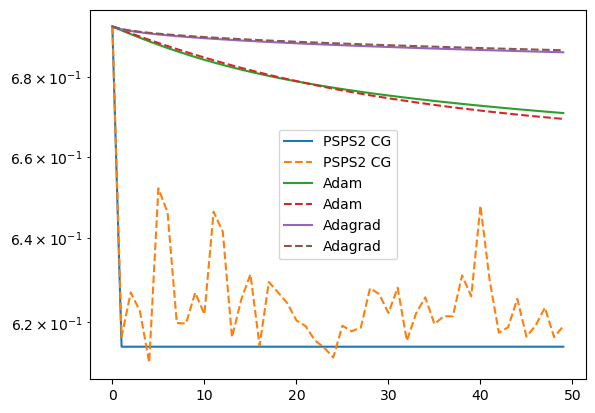

In [ ]:
plt.semilogy([x[0] for x in hist_pcg_none], label="PSPS2 CG")
plt.semilogy([x[0] for x in hist_pcg_none_scaled], linestyle="--", label="PSPS2 CG")

plt.semilogy([x[0] for x in hist_adam], label="Adam")
plt.semilogy([x[0] for x in hist_adam_scaled], linestyle="--", label="Adam")

plt.semilogy([x[0] for x in hist_adagrad], label="Adagrad")
plt.semilogy([x[0] for x in hist_adagrad_scaled], linestyle="--", label="Adagrad")


plt.legend()

In [ ]:
for seed in [0, 1, 2, 3, 4]:
    for precond in ["none", "scaling_vec", "hess_diag"]:
        for data, target, loader, scale in zip([train_data, train_data_scaled], [train_target, train_target], [train_dataloader, train_dataloader_scaled], [0, 2]):
            hist = run_psps2(data, target, loader, EPOCHS, precond, seed, scaling_vec=scaling_vec)
            save_results(hist, dataset_name, 1.0, scale, batch_size, EPOCHS, loss_function.__name__, "psps2", 1.0, precond, "none", 1000, seed)

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 0.16975426525350082 | Accuracy: 0.0
[1/100] | Loss: 0.5464040575530587 | GradNorm^2: 0.09227380028199492 | Accuracy: 0.919
[2/100] | Loss: 0.4642990404278587 | GradNorm^2: 0.05739372157240798 | Accuracy: 0.925
[3/100] | Loss: 0.41189973088516596 | GradNorm^2: 0.03976194794898007 | Accuracy: 0.928
[4/100] | Loss: 0.3749529687356867 | GradNorm^2: 0.02959971841094788 | Accuracy: 0.936
[5/100] | Loss: 0.34711245853767364 | GradNorm^2: 0.02314574122551069 | Accuracy: 0.94
[6/100] | Loss: 0.32515060341798685 | GradNorm^2: 0.018750139068463526 | Accuracy: 0.946
[7/100] | Loss: 0.30724186213128735 | GradNorm^2: 0.01559752900298193 | Accuracy: 0.952
[8/100] | Loss: 0.2922676686108632 | GradNorm^2: 0.01324521535618529 | Accuracy: 0.958
[9/100] | Loss: 0.2794995133513065 | GradNorm^2: 0.0114345390034796 | Accuracy: 0.959
[10/100] | Loss: 0.26843976079802034 | GradNorm^2: 0.010005322481841158 | Accuracy: 0.958
[11/100] | Loss: 0.2587352688300567 | G

In [ ]:
for lr in [0.1, 0.01]:
    for seed in [0, 1, 2, 3, 4]:
        for data, target, loader, scale in zip([train_data, train_data_scaled], [train_target, train_target], [train_dataloader, train_dataloader_scaled], [0, 2]):
            hist = run_optimizer(Adam, data, target, loader, EPOCHS, seed, lr=lr)
            save_results(hist, dataset_name, 1.0, scale, batch_size, EPOCHS, loss_function.__name__, "adam", lr, "none", "none", 1000, seed)

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 0.16975426525350082 | Acc: 0.0


[1/100] | Loss: 0.48276100396488736 | GradNorm^2: 0.07087719635588617 | Acc: 0.783
[2/100] | Loss: 0.3715246854849239 | GradNorm^2: 0.036640239307962494 | Acc: 0.845
[3/100] | Loss: 0.3055533193356402 | GradNorm^2: 0.023069277953531923 | Acc: 0.885
[4/100] | Loss: 0.2589321363567373 | GradNorm^2: 0.015270375054293149 | Acc: 0.908
[5/100] | Loss: 0.22326314066601685 | GradNorm^2: 0.010227766381014039 | Acc: 0.928
[6/100] | Loss: 0.19551302486621544 | GradNorm^2: 0.006975649709414518 | Acc: 0.939
[7/100] | Loss: 0.17406255929034017 | GradNorm^2: 0.004973028590415649 | Acc: 0.951
[8/100] | Loss: 0.15739244180999157 | GradNorm^2: 0.0037464174925470424 | Acc: 0.965
[9/100] | Loss: 0.1441239932792416 | GradNorm^2: 0.0029179964312227693 | Acc: 0.973
[10/100] | Loss: 0.13325315051333095 | GradNorm^2: 0.002287518184429416 | Acc: 0.977
[11/100] | Loss: 0.12418183371456652 | GradNorm^2: 0.0017959841324572485 | Acc: 0.979
[12/100] | Loss: 0.11655343203657495 | GradNorm^2: 0.0014377859295246964 | A

In [ ]:
for lr in [0.1, 0.01]:
    for seed in [0, 1, 2, 3, 4]:
        for data, target, loader, scale in zip([train_data, train_data_scaled], [train_target, train_target], [train_dataloader, train_dataloader_scaled], [0, 2]):
            hist = run_optimizer(Adagrad, data, target, loader, EPOCHS, seed, lr=lr)
            save_results(hist, dataset_name, 1.0, scale, batch_size, EPOCHS, loss_function.__name__, "adagrad", lr, "none", "none", 1000, seed)

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Acc: 0.0
[1/100] | Loss: 0.4267313317047231 | GradNorm^2: 0.15906012594621738 | Acc: 0.896356474643033
[2/100] | Loss: 0.36805530742033943 | GradNorm^2: 0.21169543342152553 | Acc: 0.9538404726735599
[3/100] | Loss: 0.30519619323576047 | GradNorm^2: 0.09512913701193289 | Acc: 0.8985721319547021
[4/100] | Loss: 0.25991123620070333 | GradNorm^2: 0.033765976368486134 | Acc: 0.9362383062530774
[5/100] | Loss: 0.23696173654892344 | GradNorm^2: 0.02139276446209543 | Acc: 0.9234367306745446
[6/100] | Loss: 0.2201584432833685 | GradNorm^2: 0.01748539004766935 | Acc: 0.9387001477104875
[7/100] | Loss: 0.20645515848058654 | GradNorm^2: 0.014814919701432606 | Acc: 0.9446085672082718
[8/100] | Loss: 0.19490185926823628 | GradNorm^2: 0.012815379217540567 | Acc: 0.9494091580502215
[9/100] | Loss: 0.1849751500047877 | GradNorm^2: 0.011244104927632973 | Acc: 0.9532250123092073
[10/100] | Loss: 0.17632005877807663 | GradNorm^2: 0.009

[32/100] | Loss: 0.10943059493363523 | GradNorm^2: 0.004001677322088999 | Acc: 0.9766125061546036
[33/100] | Loss: 0.10772808938840293 | GradNorm^2: 0.0038293187708297732 | Acc: 0.9780896110290497
[34/100] | Loss: 0.1060925239260305 | GradNorm^2: 0.003668465745653285 | Acc: 0.9794436238306253
[35/100] | Loss: 0.10451966655634863 | GradNorm^2: 0.0035181006096282907 | Acc: 0.9798129000492368
[36/100] | Loss: 0.10300564956665108 | GradNorm^2: 0.003377316799985375 | Acc: 0.9805514524864599
[37/100] | Loss: 0.10154693015452661 | GradNorm^2: 0.0032453044711516304 | Acc: 0.9810438207779419
[38/100] | Loss: 0.1001402561512272 | GradNorm^2: 0.0031213382765440897 | Acc: 0.9812900049236829
[39/100] | Loss: 0.09878263607264672 | GradNorm^2: 0.003004766928873242 | Acc: 0.9819054652880355
[40/100] | Loss: 0.09747131286456662 | GradNorm^2: 0.0028950042463517247 | Acc: 0.9823978335795175
[41/100] | Loss: 0.09620374081387267 | GradNorm^2: 0.0027915214458425373 | Acc: 0.982767109798129
[42/100] | Loss: 

KeyboardInterrupt: 